In [73]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [74]:
# Specify transforms using torchvision.transforms as transforms
# library
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [112]:
# Load in each dataset and apply transformations using
# the torchvision.datasets as datasets library
train_set = datasets.ImageFolder('/home/ec2-user/SageMaker/train', transform = transformations)
val_set = datasets.ImageFolder('/home/ec2-user/SageMaker/test', transform = transformations)
train_set, val_set

(Dataset ImageFolder
     Number of datapoints: 2637
     Root location: /home/ec2-user/SageMaker/train
     StandardTransform
 Transform: Compose(
                Resize(size=255, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 660
     Root location: /home/ec2-user/SageMaker/test
     StandardTransform
 Transform: Compose(
                Resize(size=255, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [113]:
# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=True)

In [114]:
# Get pretrained model using torchvision.models as models library
model = models.densenet161(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

In [115]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.classifier.in_features
num_labels = 2
classifier = nn.Sequential(nn.Linear(classifier_input, 1624),
                           nn.ReLU(),
                           nn.Linear(1624, 812),
                           nn.ReLU(),
                           nn.Linear(812, num_labels),
                           nn.LogSoftmax(dim=1))
# Replace default classifier with new classifier
model.classifier = classifier

In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [117]:
# Set the error function using torch.nn as nn library
criterion = nn.NLLLoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.classifier.parameters())

In [118]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(val_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    # Print out the information
    print('Accuracy: ', accuracy/len(val_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))


1 / 83
2 / 83
3 / 83
4 / 83
5 / 83
6 / 83
7 / 83
8 / 83
9 / 83
10 / 83
11 / 83
12 / 83
13 / 83
14 / 83
15 / 83
16 / 83
17 / 83
18 / 83
19 / 83
20 / 83
21 / 83
22 / 83
23 / 83
24 / 83
25 / 83
26 / 83
27 / 83
28 / 83
29 / 83
30 / 83
31 / 83
32 / 83
33 / 83
34 / 83
35 / 83
36 / 83
37 / 83
38 / 83
39 / 83
40 / 83
41 / 83
42 / 83
43 / 83
44 / 83
45 / 83
46 / 83
47 / 83
48 / 83
49 / 83
50 / 83
51 / 83
52 / 83
53 / 83
54 / 83
55 / 83
56 / 83
57 / 83
58 / 83
59 / 83
60 / 83
61 / 83
62 / 83
63 / 83
64 / 83
65 / 83
66 / 83
67 / 83
68 / 83
69 / 83
70 / 83
71 / 83
72 / 83
73 / 83
74 / 83
75 / 83
76 / 83
77 / 83
78 / 83
79 / 83
80 / 83
81 / 83
82 / 83
83 / 83
1 / 21
2 / 21
3 / 21
4 / 21
5 / 21
6 / 21
7 / 21
8 / 21
9 / 21
10 / 21
11 / 21
12 / 21
13 / 21
14 / 21
15 / 21
16 / 21
17 / 21
18 / 21
19 / 21
20 / 21
21 / 21
Accuracy:  0.8553571417218163
Epoch: 0 	Training Loss: 0.479067 	Validation Loss: 0.334801
1 / 83
2 / 83
3 / 83
4 / 83
5 / 83
6 / 83
7 / 83
8 / 83
9 / 83
10 / 83
11 / 83
12 / 83
13 / 83


In [119]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [120]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [121]:
model.cpu()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [122]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [123]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [124]:
pwd

'/home/ec2-user/SageMaker'

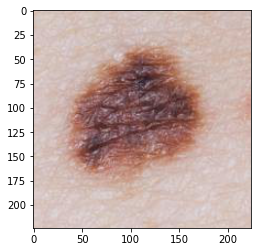

The model is  99.68301653862 % certain that the mole is Malignant 


In [149]:
# Process Image
image = process_image('/home/ec2-user/SageMaker/melanoma2.jpeg')
# Give image to model to predict output
top_prob, top_class = predict(image, model)
# Show the image
show_image(image)
plt.show()
# Print the results
if top_class == 1:
    print("The model is ", top_prob*100, "% certain that the mole is Malignant ")
else: 
    print("The model is ", top_prob*100, "% certain that the mole is Benign ")
